# Predicting Memory Encoding using an OpenBCI

General Writeup: http://lambdaloop.com/predicting-memory-encoding-using-openbci

Note: This is currently only set up to calculcate and plot average ERP's differences for 1 participant's data (of the 3 we have so far). Upon getting more participants, this will be expanded to evaluate effects across all participants. 

### Document Overview

- (1) Import packages
- (2) Import data & display a small preview
- (3) Create word-related data structures: word_cues & word_dict
- (4) Cleaning up the brain region per channel
- (5) Cleaning up the raw eeg data 

    - 5a) Preliminary data inspection via line plots & spectograms
    - 5b) Preliminary trimming of series' heads & tails to remove noise. 
        - eeg_raw -> eeg_trimmed
    - 5c)  Applying Butterworth Filter and shows a basic before/after line plot 
        - eeg_trimmed -> eeg_post_butterworth
    - 5d)  Using ICA to identify and remove eyeblink artifcats
        - ceeg_post_butterworth -> eeg_no_eyeblinks
- (6) Create word-related data structures: word_starts
- (7) Create eeg_trials: slicing the eeg data per word presentation
    - eeg_no_eyeblinks -> eeg_trials
- (8) Plotting the differences b/w eeg trials where the word was recognized and when it wasn't

### (1) Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy import signal

from sklearn.decomposition import FastICA

from IPython.display import display

### (2) Import data & display a small preview

In [2]:
eeg_raw = pd.read_csv('../data_real/eeg_zhanna.csv')
words = pd.read_csv('../data_real/words_zhanna_labeled.csv')
brain_region_per_channel_list = open('../data_real/eeg_zhanna_channels.txt').readlines()

In [3]:
for imported_dataset in [eeg_raw,words,brain_region_per_channel_list]:
    display(imported_dataset[:4])

,channel_0,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,time,tag
0,5122340,2326871,4909532,1909612,3610901,4706622,2950398,5006381,1.468798e+09,0
1,5151211,2352586,4932233,1920437,3636382,4748018,2968450,5002527,1.468798e+09,0
2,5166898,2373883,4944399,1914734,3646449,4724236,2947837,4990509,1.468798e+09,0
3,5132878,2344088,4918182,1903538,3617601,4680006,2929766,4996053,1.468798e+09,0


,Unnamed: 0,Unnamed: 0.1,level_0,index,freq,syl,let,word,imag,conc,meaning,list,id,is_shown,recognized
0,0,0,154,514,100,2,5,ocean,6.77,6.90,8.76,1,515,1,False
1,1,1,7,26,4,4,7,malaria,4.83,5.66,6.64,1,27,1,True
2,2,2,88,314,100,1,5,table,6.50,7.00,7.60,1,315,1,False
3,3,3,134,433,100,2,6,effort,3.33,2.22,5.75,1,434,1,True


['1468798457\n', '1 O1\n', '2 O2\n', '3 O1 but more left, almost T5\n']

### (3) Create word-related data structures: word_cues & word_dict

- **word_cues** -  shows which word (if any) is presented to the participant at a given time slice
- **word_dict**  - a dictionary of information about words themselves

In [4]:
# Indexes the words dataframe by "word" and creates a dictionary out of it.
word_dict = words.set_index("word").T.to_dict()

# import pprint
# pprint.pprint(word_dict)

# {'abbess': {'Unnamed: 0': 86,
#             'Unnamed: 0.1': 86,
#             'conc': 4.78,
#             'freq': 1,
#             'id': 415,
#             'imag': 2.97,
#             'index': 414,
#             'is_shown': 0,
#             'let': 6,
#             'level_0': 123,
#             'list': 1,
#             'meaning': 2.48,
#             'recognized': False,
#             'syl': 2},
#  'abode': {'Unnamed: 0': 30,
#            'Unnamed: 0.1': 30,
#            'conc': 6.31,
#             ...

In [5]:
word_cues = np.array(eeg_raw.ix[:, 'tag'])

## 'word_cues' - This indicates what the participant views on the screen for the particular time interval. 
                
##  It starts off with "0" before the application has started, and then alternates between the presented word 
## and "focus" to indicate the intermediary breaks between words. 

# For example, for the first 4000 thousand rows of word cues, this samples every 200th element 
# to give an overview of what this looks like
# print [word for word in word_cues[:4000:200]]

# ['0', '0', '0', '0', '0', 'ocean', 'ocean', 'ocean', 'focus', 'malaria',  'malaria', 'focus', 'table',
#  'table', 'focus', 'effort', 'effort', 'focus', 'speaker', 'speaker']

### (4) Cleaning up the brain region per channel

These are encoded using the [standard 10-20 system (EEG).](https://en.wikipedia.org/wiki/10-20_system_(EEG) This matches the EEG channel with it's corresponding mapping to a particular brain region:

<img src="https://upload.wikimedia.org/wikipedia/commons/7/70/21_electrodes_of_International_10-20_system_for_EEG.svg" width="300" />

In [6]:
# Removing noise from brain_region_per_channel_list
brain_region_per_channel_list = brain_region_per_channel_list[1:] # Removing identifier key (the first element)
brain_region_per_channel_list = [line.strip() for line in brain_region_per_channel_list]  # Removing new line /n introcued from .txt and readlines()


# Converting each line of brain_region_per_channel_list into key-value pairs in a separate dictionary
channel_to_brain_region_dict = dict()
for channel in brain_region_per_channel_list:
    num, _, label = channel.partition(' ')        # Separating the first charachter num (channel) value, from it's corresponding brain region
    num = int(num) - 1                            # Re-Indexing to 0 per python standard
    channel_to_brain_region_dict[num] = label
    
channel_to_brain_region_dict    

{0: 'O1',
 1: 'O2',
 2: 'O1 but more left, almost T5',
 3: 'T3',
 4: 'T6',
 5: 'F8',
 6: 'F7',
 7: 'FP1-2'}

### (5) Cleaning up the raw eeg data 

**Inputs:** eeg_raw

**Outputs:** eeg_buttered & word_cues


This section is broken into the following componenets:
- 5a) Preliminary data inspection via line plots & spectograms
- 5b) Preliminary trimming of series' heads & tails to remove noise (Reduces eeg data from 78869 observations to 77250 by removing the first 250 rows and last 1369 rows.
- 5c)  Applying Butterworth Filter and shows a basic before/after line plot
- 5d)  Using ICA to identify and remove eyeblink artifcats

### 5a) Preliminary data inspection via line plots & spectograms

In [7]:
print eeg_raw.shape

(78869, 10)


In [8]:
eeg_raw.head(3)

,channel_0,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,time,tag
0,5122340,2326871,4909532,1909612,3610901,4706622,2950398,5006381,1.468798e+09,0
1,5151211,2352586,4932233,1920437,3636382,4748018,2968450,5002527,1.468798e+09,0
2,5166898,2373883,4944399,1914734,3646449,4724236,2947837,4990509,1.468798e+09,0


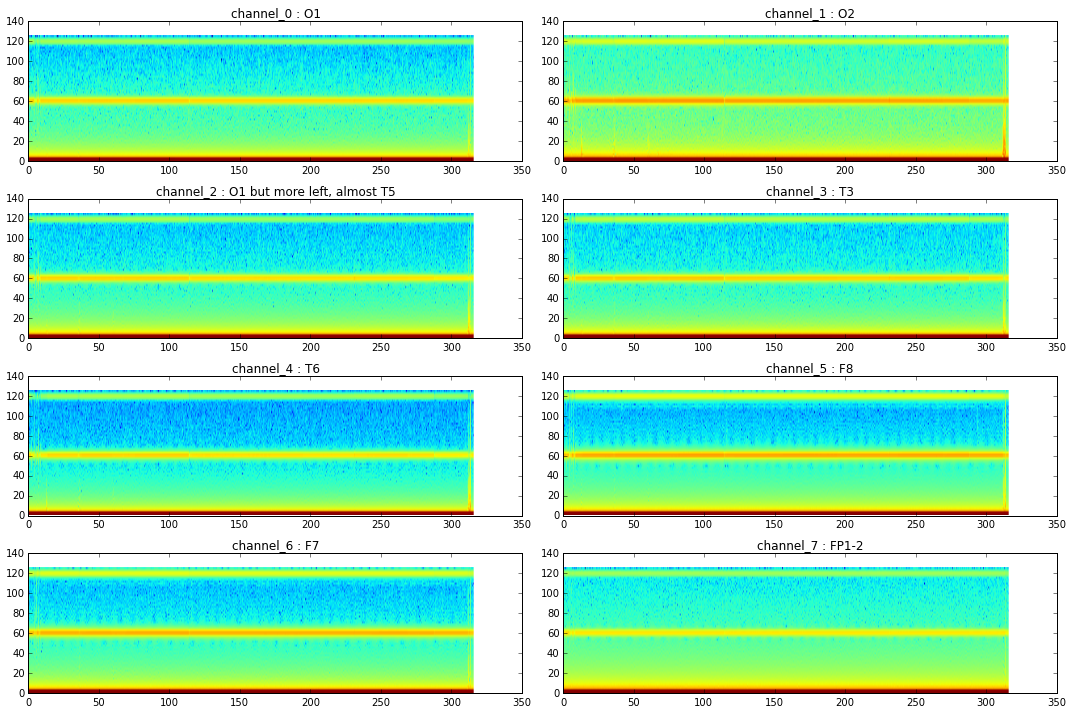

In [9]:
# Spectograms
fig = plt.figure(figsize=(15,10))

for c in range(8):
    channel_name = eeg_raw.columns[c]

    ax = plt.subplot(4,2,c+1)
    _ = plt.specgram(eeg_raw[channel_name], NFFT=128, Fs=250, noverlap=64)
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    ax.set_title(title)

fig.tight_layout()
plt.show()

#### Plot Observation: DC line noise clearly visible around 60 hz ...

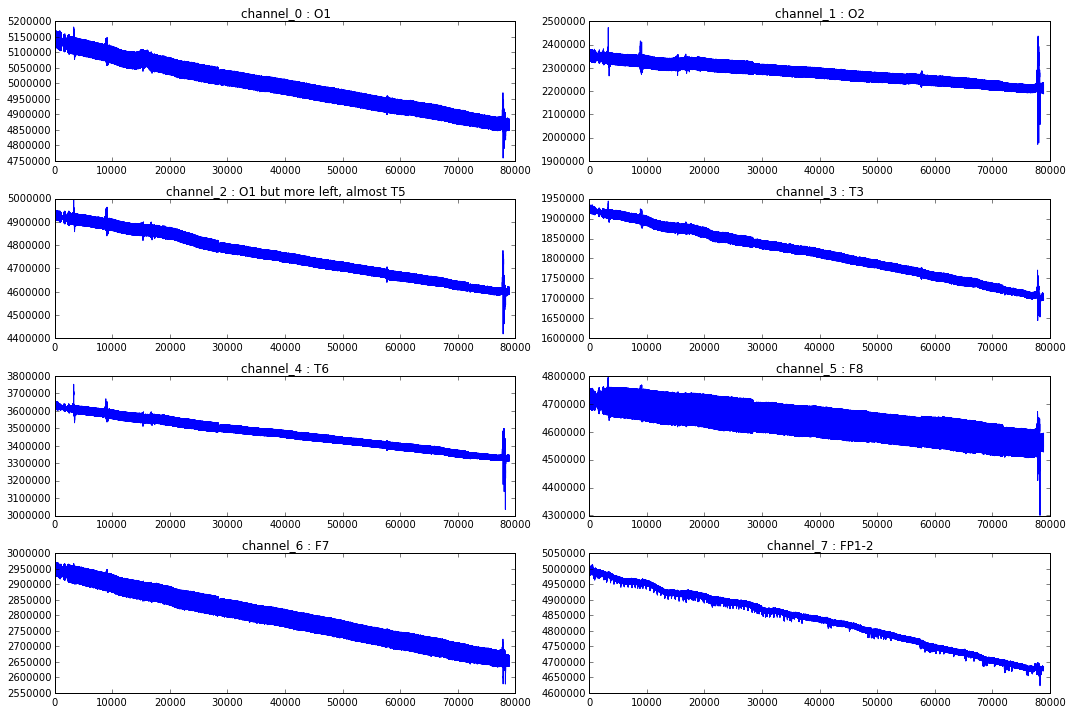

In [10]:
# Line Charts
fig = plt.figure(figsize=(15,10))

for c in range(8):
    channel_name = eeg_raw.columns[c]

    ax = plt.subplot(4,2,c+1)
    ax.plot(eeg_raw[channel_name])
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    ax.set_title(title)

fig.tight_layout()
plt.show()

##### Plot Observations: There seems to be some consistent noise at the ends of the plots (maybe the eeg was recording after the electrode had been removed from the participants head?) and also in the begining. 

### 5b) Preliminary trimming of series' heads & tails to remove noise:

Abnormalities found in three distinct areas:

**In the head:** First around ~3500 observations in and second around ~9000 observations in
- *Action Outstanding:* !!!! This is still an outstanding issue! - The data was not trimmed. Further investigation necessary 

**In the tail:** After around 77500 observations in. 
- *Action Performed:* The series were all trimmed to just 77500. 


##### Examining the begining of series

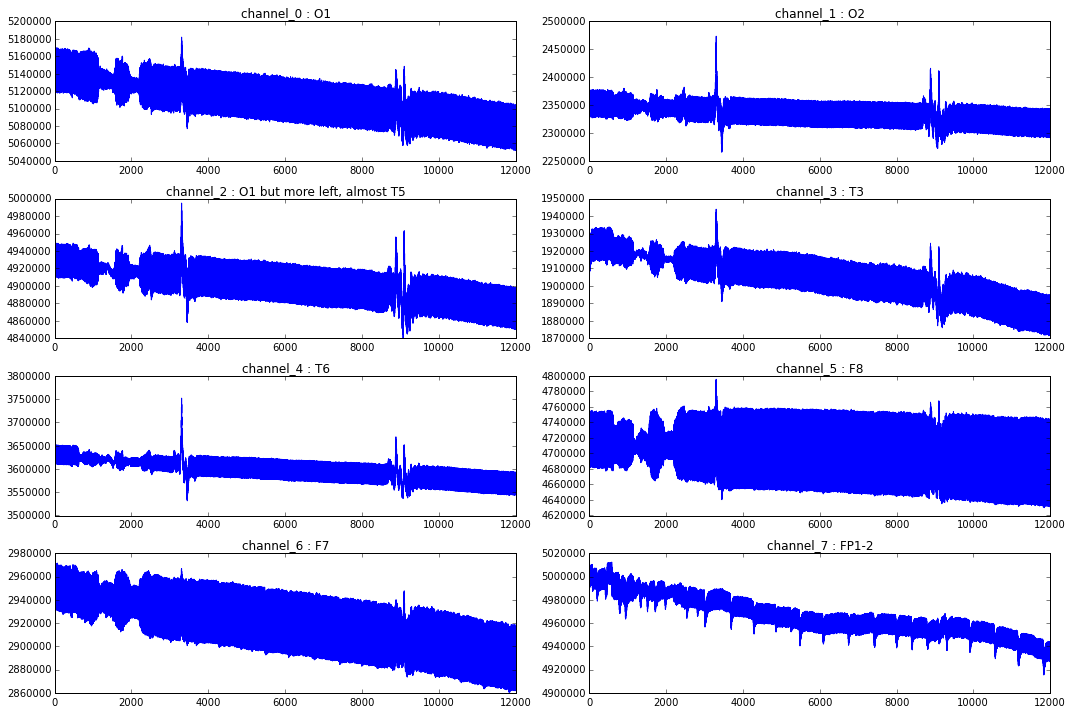

In [11]:
fig = plt.figure(figsize=(15,10))

for c in range(8):
    channel_name = eeg_raw.columns[c]

    ax = plt.subplot(4,2,c+1)
    ax.plot(eeg_raw[channel_name][:12000])
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    ax.set_title(title)

fig.tight_layout()
plt.show()

##### Plot Observations (Begining of Series): It seems like the weirdness around 3500 rows in and again around 9000

In [12]:
# Seeing what words would be impacted if we were to trim off the front
print set(word_cues[:3500])
print
print set(word_cues[:9500])

set(['malaria', 'focus', 'ocean', '0', 'speaker', 'table', 'effort'])

set(['hardship', 'malaria', 'scarlet', 'series', 'focus', 'ocean', '0', 'discretion', 'speaker', 'forest', 'enterprise', 'table', 'horsehair', 'vocation', 'effort', 'busybody'])


##### Temporarily deciding to not remove early data -- will need to revisit later

In [13]:
##### Examining the end of series

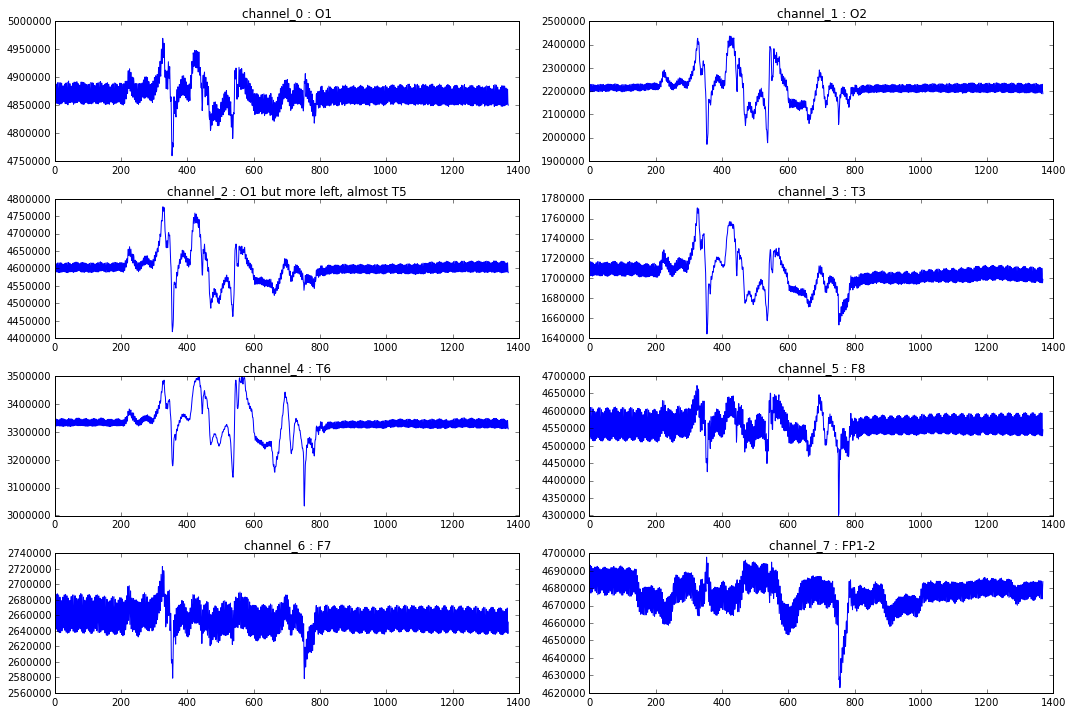

In [14]:
fig = plt.figure(figsize=(15,10))

for c in range(8):
    channel_name = eeg_raw.columns[c]

    ax = plt.subplot(4,2,c+1)
    ax.plot(eeg_raw[channel_name][77500:])
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    ax.set_title(title)

fig.tight_layout()
plt.show()

##### Plot Observations (End of Series): It seems like the weirdness at the end of the plot beings around 77500

In [15]:
print set(word_cues[77500:])

set(['focus'])


##### No words would be eliminated if we remove all series after 77500 --> Trim off the end

In [16]:
# Before:
#print len(eeg_raw)     # 78869
#print len(word_cues)   # 78869


eeg_trimmed = np.array(eeg_raw.ix[:77500-1, 0:8]) # -1 s.t. both end up having an even 77500: 
word_cues = word_cues[:77500]  

# After:
#print len(eeg_trimmed) # 77500
#print len(word_cues)   # 77500

#### 5c) Applying Butterworth Filter and shows a basic before/after line plot

In [17]:
## What this does: filter from 5 to 35 Hz
## Why it does it: replicates paper to remove DC line noise (60Hz noise) and baseline drift.
## Note: 125 is half the sampling rate (250Hz/2)
b, a = signal.butter(4, (2.0/125, 35.0/125), btype='bandpass') 
eeg_post_butterworth = signal.lfilter(b, a, eeg_trimmed, axis=0)

## Generaly, the filter needs a couple samples to converge and 500 is considered a fairly conservative amount
## Additionally, the first 500 are all 0 (set(word_cues[:500])), so we don't need these samples anyway.

eeg_post_butterworth = eeg_post_butterworth[500:]
word_cues = word_cues[500:]

#### Plotting a sample comparison - Channel 7. 

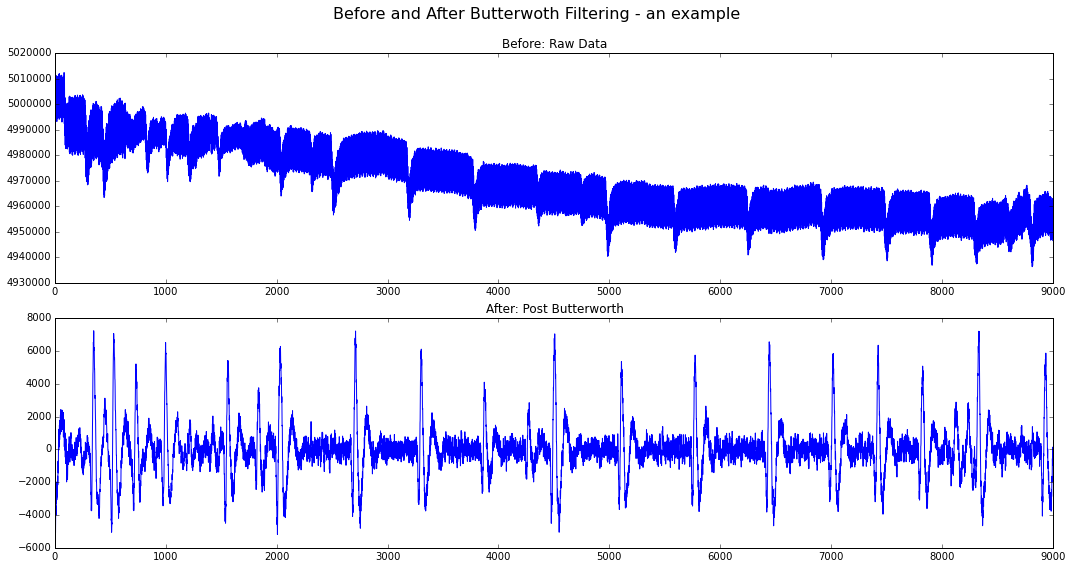

In [18]:
# Comparing the differences
# (Reducing to 9000 observations to show detail)

fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot(2,1,1)
plt.plot(eeg_trimmed[500:9500, 7]) 
ax1.set_title("Before: Raw Data")

ax1 = plt.subplot(2,1,2)
plt.plot(eeg_post_butterworth[500:9500, 7])
ax1.set_title("After: Post Butterworth")

fig.tight_layout()
plt.suptitle("Before and After Butterwoth Filtering - an example", size=16)
fig.subplots_adjust(top=0.9)

plt.show()

### 5d)  Using ICA to identify and remove eyeblink artifcats

In [19]:
# Run ICA to break down eeg signal into components
ica = FastICA()
ica_components = ica.fit_transform(eeg_post_butterworth)
means = ica.mean_.copy()
mixing = ica.mixing_.copy()

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


#### Look at the plots to find the eyeblink component 

TODO: make a more robust eyeblink component finder (i.e. that doesn't involve human intervention)

Consider these papers:
- [Via Morphological Component Analysis](https://www.hindawi.com/journals/cmmm/2017/1861645/)
- [Via Correlation w/ Frontal Cortex Channels](http://www.mdpi.com/1424-8220/13/8/10783)
- [Via Blind Component Separation](http://cb3.unl.edu/dbrainlab/wp-content/uploads/sites/2/2013/12/4c.-CA-Joyce-artifact-removal.pdf)

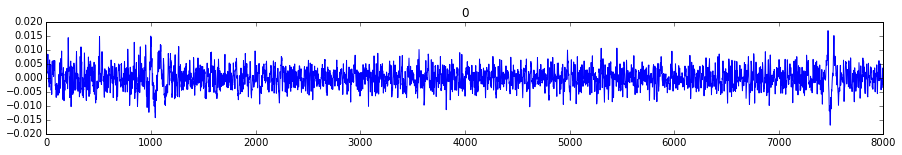

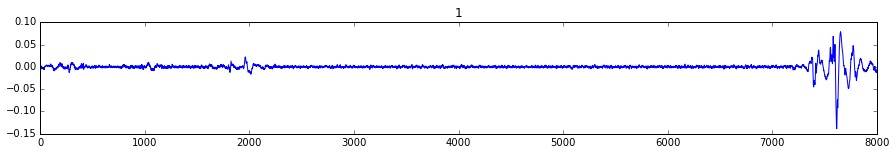

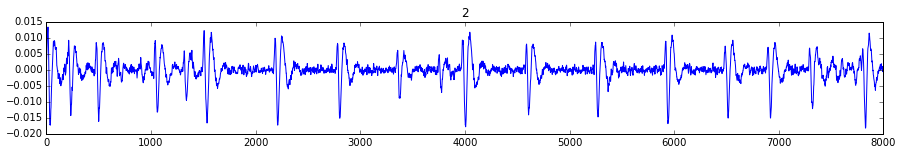

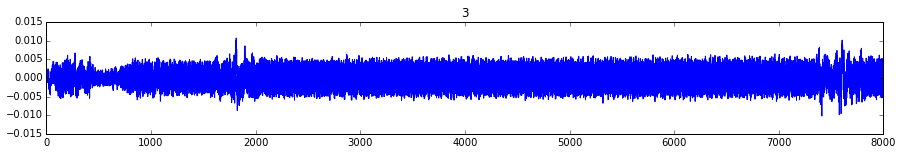

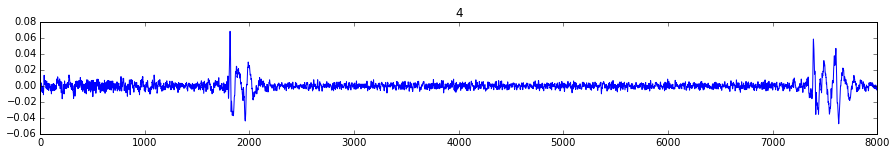

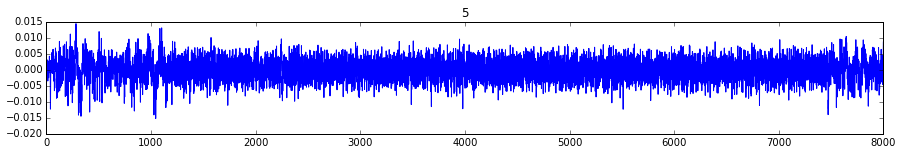

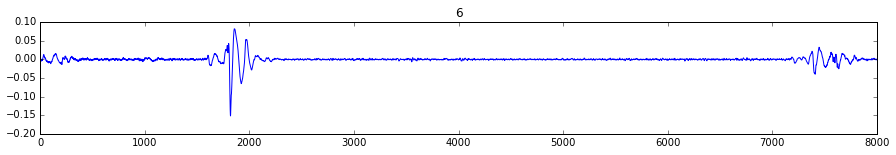

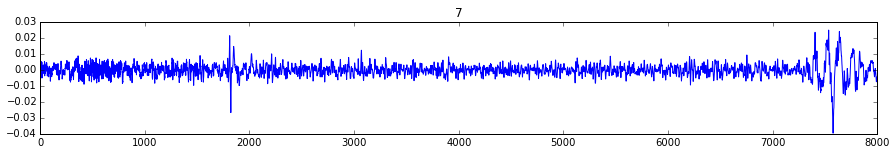

In [20]:
for i in range(ica.components_.shape[0]):
    plt.figure(figsize=(15,2))
    plt.plot(ica_components[1000:9000, i])
    plt.title(i)

#### Plot Observation: Eye-blinks seem to be the 0th component because of a) shape b) frequency of occuring ~2 seconds (every 2 s = 500 rows = 2 * fps = 2 * 250)

In [29]:
#Removing eyeblink artifacts
eye_blinks_ix = 2
mixing[:, eye_blinks_ix] = 0 # setting eyeblink component to 0
eeg_no_eyeblinks = ica_components.dot(mixing.T) + means # this is the ICA inverse transform

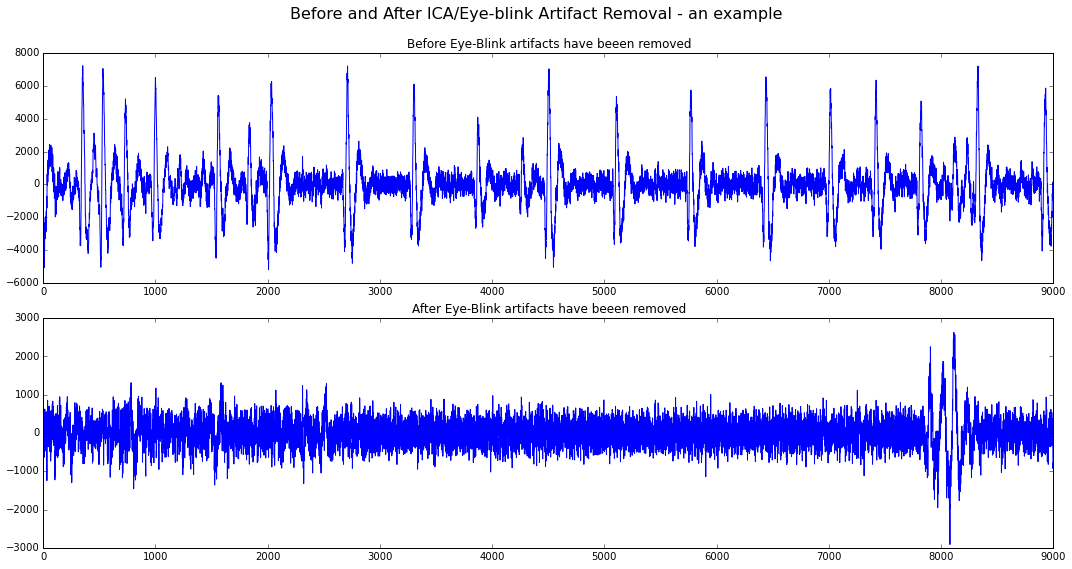

In [30]:
# Comparing the differences
# (Reducing to 9000 observations to show detail)


fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot(2,1,1)
plt.plot(eeg_post_butterworth[500:9500, 7])
ax1.set_title("Before Eye-Blink artifacts have beeen removed")

ax1 = plt.subplot(2,1,2)
plt.plot(eeg_no_eyeblinks[500:9500, 7])
ax1.set_title("After Eye-Blink artifacts have beeen removed")

fig.tight_layout()
plt.suptitle("Before and After ICA/Eye-blink Artifact Removal - an example", size=16)
fig.subplots_adjust(top=0.9)

plt.show()

###  (6) Create word-related data structures: word_starts

**"word_starts"** is effectively **word_dict** but including a **start_index** (effective timestamp) of when the word was first presented.

Note: this has to be done after the head/tail eeg trimming so that the row indicies stay consistent. 

In [23]:
word_starts = []
prev_word = None

for index, word in enumerate(word_cues):
    if word != 'focus' and word != '0' and word != prev_word:
        word_starts.append( {'start_index': index, 
                             'word': word,
                             'dict': word_dict[word]} )
    prev_word = word

In [24]:
for x in word_starts[:2]:
    print x
    print    

{'dict': {'index': 514, 'Unnamed: 0': 0, 'imag': 6.77, 'list': 1, 'recognized': False, 'syl': 2, 'Unnamed: 0.1': 0, 'meaning': 8.76, 'conc': 6.9, 'let': 5, 'freq': 100, 'level_0': 154, 'id': 515, 'is_shown': 1}, 'word': 'ocean', 'start_index': 483}

{'dict': {'index': 26, 'Unnamed: 0': 1, 'imag': 4.83, 'list': 1, 'recognized': True, 'syl': 4, 'Unnamed: 0.1': 1, 'meaning': 6.64, 'conc': 5.66, 'let': 7, 'freq': 4, 'level_0': 7, 'id': 27, 'is_shown': 1}, 'word': 'malaria', 'start_index': 1111}



In [25]:
## this confirms that there's ~2.5 seconds between words
np.diff([x['start_index'] for x in word_starts]) / 250.0

array([ 2.512,  2.512,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,
        2.512,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,  2.512,
        2.508,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.512,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.508,  2.516,  2.508,
        2.516,  2.508,  2.512,  2.512,  2.508,  2.516,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.512,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,
        2.512,  2.512,  2.508,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.508,  2.512,  2.516,  2.508,  2.512,  2.512,  2.508,  2.512,
        2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,
        2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,  2.508,
      

### (7) Create eeg_trials: slicing the eeg data per word presentation

In [26]:
erp_duration = int(250*2.5)                # 2.5 seconds
eeg_trials = np.zeros((8, len(word_starts), erp_duration))
# eeg_trials.shape # (8, 120, 625)

time_markers = np.arange(0, erp_duration, 1) / 250.0 - 0.5

for c in range(8):
    for i in range(len(word_starts)):
        word_dict = word_starts[i]
        start_index = word_dict['start_index']
        # At 250fps: 
        # 125 samples = 0.5s, 500 samples = 2.0 s
        # We want 0.5s before the stimulus presentation and 2.0 seconds after
        eeg_trials[c, i, :] = eeg_no_eyeblinks[start_index-125:start_index+500, c] 

##### Plotting mean ERP across all words per channel

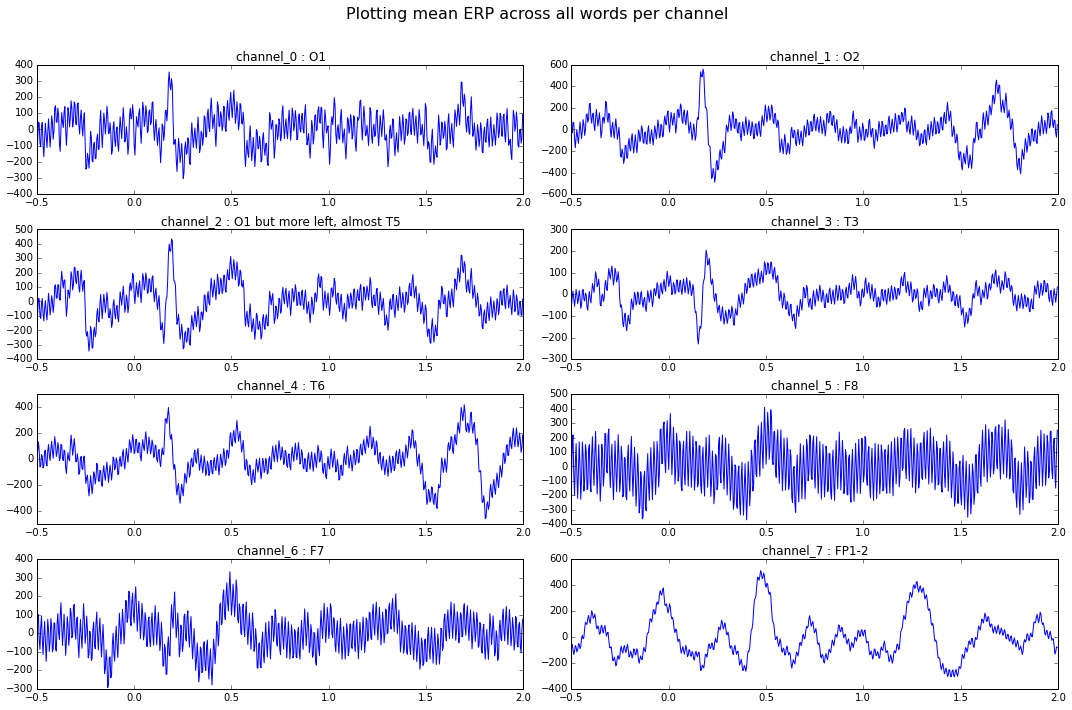

In [27]:
fig = plt.figure(figsize=(15,10))

for c in range(8):
    ax = plt.subplot(4,2,c+1)
    _ = plt.plot(time_markers, np.mean(eeg_trials[c], axis=0))
    
    channel_name = eeg_raw.columns[c]
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    ax.set_title(title)

fig.tight_layout()
plt.suptitle("Plotting mean ERP across all words per channel", size=16)
fig.subplots_adjust(top=0.9)
plt.show()

### (8) Plotting the differences b/w eeg trials where the word was recognized and when it wasn't

This shows the ERPs for -0.5s to 2.5s with 0s = when stimulus is shown
- blue is for remembered words
- red is for not remembered words

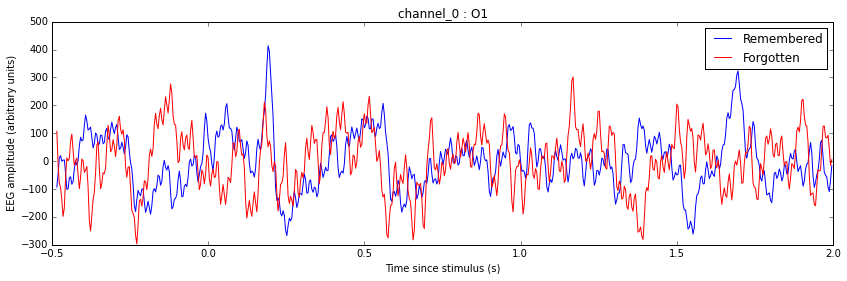

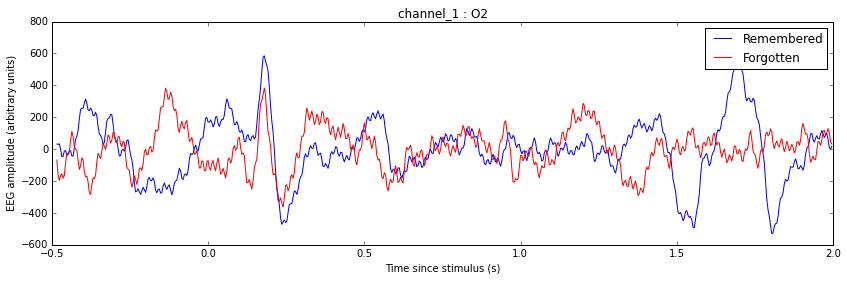

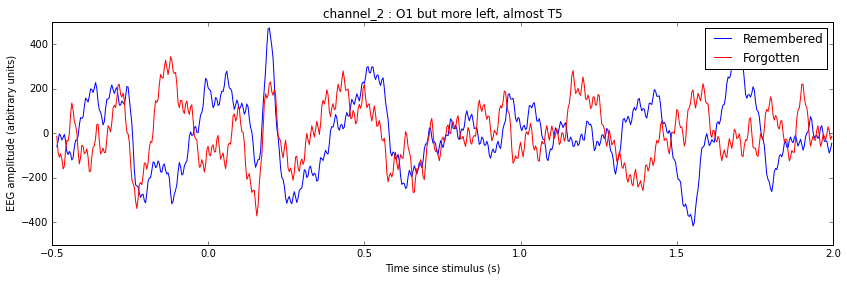

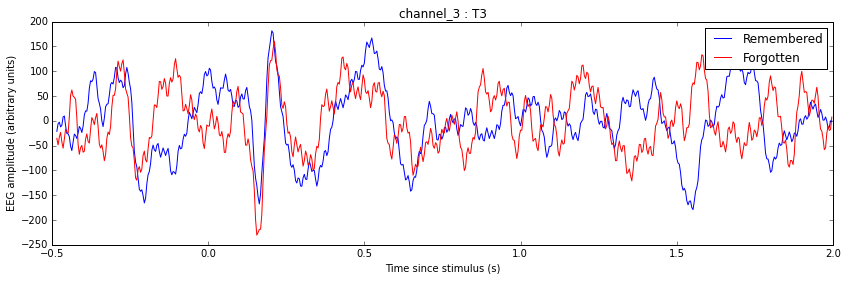

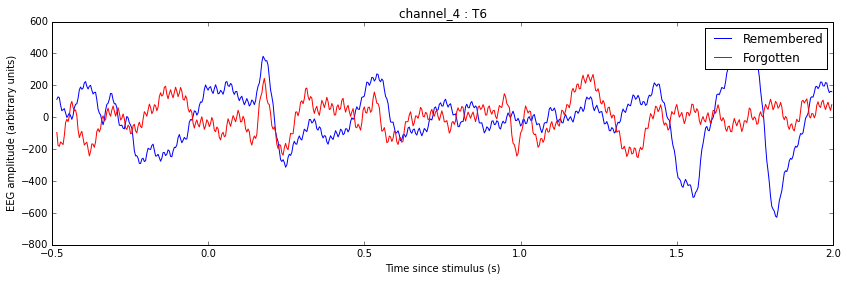

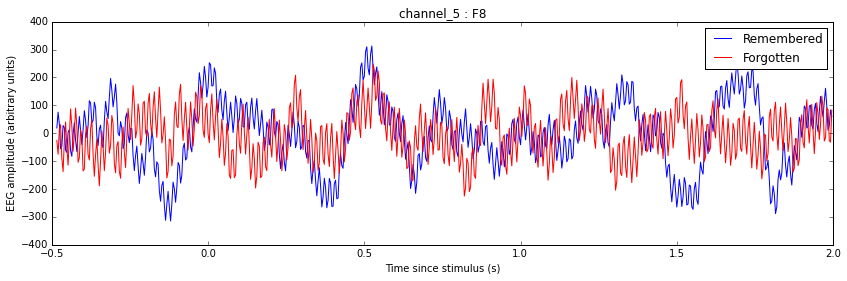

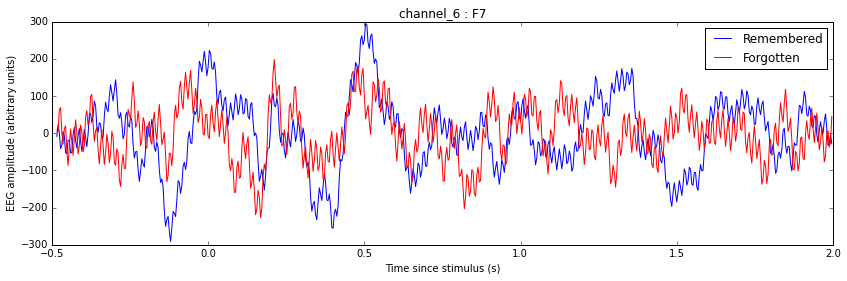

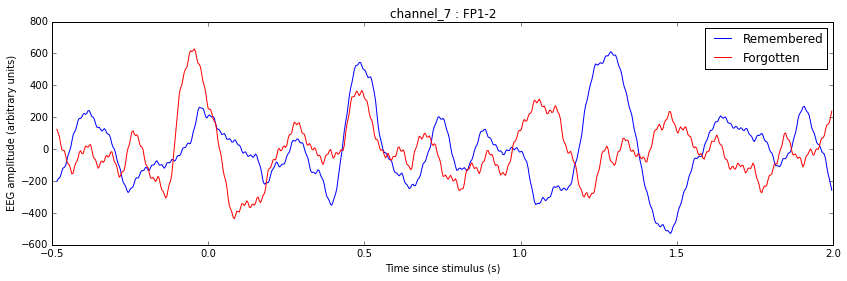

In [28]:
### A moving average is taken to smooth out series
### TODO: Investigate further smoothing options at a later time... especially around channels 5 & 6

N_AVG = 5
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

recognized = np.array([w['dict']['recognized'] for w in word_starts])

for c in range(8):
    plt.figure(figsize=(14, 4))
    
    rec = np.mean(eeg_trials[c][recognized], axis=0)
    rec = moving_average(rec, n=N_AVG)
    _ = plt.plot(time_markers[(N_AVG-1):], rec, c='blue', label = "Remembered")
    
    not_rec = np.mean(eeg_trials[c][~recognized], axis=0)
    not_rec = moving_average(not_rec, n=N_AVG)
    _ = plt.plot(time_markers[(N_AVG-1):], not_rec, c='red', label = "Forgotten")

    
    channel_name = eeg_raw.columns[c]    
    title = channel_name+" : "+channel_to_brain_region_dict[c]
    plt.title(title)
    
    plt.xlabel('Time since stimulus (s)')
    plt.ylabel('EEG amplitude (arbitrary units)')
    
    plt.legend()